In this submission, intermediate techniques will be adopted to improve the result.

In [1]:
import numpy as np
import pandas as pd

train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

### Data handling

In the last submission, I have checked there is no null value so I don't repeat the steps here.

In [2]:
train_dataset = train_dataset.drop(["id"], axis = 1)
target = train_dataset["target"]

Check if the dataset is imbalanced:

In [3]:
train_dataset.columns[abs(train_dataset.skew(axis=0))>0.5]

Index(['target'], dtype='object')

Skewness is to measure the asymmetry of the probability distribution of a real-valued random variable about its mean. As observed from the result, target is a column with skewness. We could further plot the data in target column to see the imbalance.

In [4]:
import matplotlib.pyplot as plt

target_classes = ['0','1']
number_of_1 = target.sum()
number_of_0 = len(target) - number_of_1
target_counts = [number_of_0, number_of_1]

([<matplotlib.patches.Wedge at 0x226ac6d6b80>,
 [Text(0.46835717599151966, 0.995309778760989, '0'),
  Text(-0.4683571759915193, -0.9953097787609891, '1')],
 [Text(0.25546755054082887, 0.5428962429605394, '36.0%'),
  Text(-0.2554675505408287, -0.5428962429605395, '64.0%')])

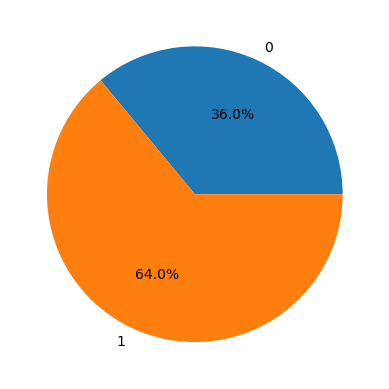

In [5]:
fig, ax = plt.subplots()
ax.pie(target_counts, labels=target_classes, autopct='%1.1f%%')

As shown in the pie chart, "1" counts for 64.0% in target class of the training dataset. The result seems imbalanced.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_dataset.drop('target',axis=1), target, test_size = 0.25, random_state = 42, shuffle=True, stratify=target)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(187, 300) (63, 300) (187,) (63,)


As we found that target column is a biased data, stratify could be used to overcome train_test_split’s biased random sampling problem with a more even distribution, to improve accuracy of the final result.

In [7]:
print(y_train.value_counts())
print(y_test.value_counts())

1.0    120
0.0     67
Name: target, dtype: int64
1.0    40
0.0    23
Name: target, dtype: int64


### Features selection

In this session, mutual_info_classif from sklearn package will be used to measure the dependency of features with the target, in order to select the features that are more correlated.

In [8]:
from sklearn.feature_selection import mutual_info_classif

mic = mutual_info_classif(x_train, y_train, random_state=42)

In [9]:
selected_features = np.array(mic > 0.02)
print('number of selected columns',selected_features.sum())
print('number of selected columns',x_train.columns[selected_features])

number of selected columns 93
number of selected columns Index(['2', '4', '9', '11', '13', '14', '17', '18', '24', '28', '31', '33',
       '36', '39', '44', '45', '48', '53', '58', '61', '67', '68', '73', '76',
       '80', '81', '82', '87', '88', '91', '92', '96', '98', '100', '101',
       '106', '108', '116', '117', '119', '122', '126', '130', '131', '133',
       '137', '138', '139', '140', '145', '146', '152', '162', '165', '169',
       '170', '171', '174', '176', '187', '189', '190', '193', '199', '201',
       '204', '212', '217', '219', '220', '225', '229', '230', '231', '235',
       '236', '237', '245', '247', '248', '254', '256', '267', '276', '279',
       '280', '282', '283', '287', '289', '290', '298', '299'],
      dtype='object')


Drop those features with low dependency from dataset:

In [10]:
dropped_features = x_train.columns[~selected_features]
x_train.drop(dropped_features,axis= 1,inplace= True)
x_test.drop(dropped_features,axis= 1 ,inplace= True)
train_dataset.drop(dropped_features,axis= 1 ,inplace= True)
test_dataset.drop(dropped_features,axis= 1 ,inplace= True)

### Model training

As SVM is a popular supervised machine learning classification algorithm that could achieve great result, I tried to use this model. Performances of Gaussian Kernel and Sigmoid Kernel will be compared to find a better model for this dataset. As the dataset was found to be imbalanced in the previous session, I put a class_weight parameter here. Gamma values were adjusted according to the performance and to avoid overfitting.

In [11]:
from sklearn.svm import SVC

rbf_svclassifier = SVC(kernel='rbf', class_weight={0: 1.8, 1: 1.0}, random_state=42, gamma= 0.0008)
rbf_svclassifier.fit(x_train, y_train)

SVC(class_weight={0: 1.8, 1: 1.0}, gamma=0.0008, random_state=42)

In [12]:
rbf_y_pred = rbf_svclassifier.predict(x_test)

In [13]:
from sklearn.metrics import accuracy_score

print("Accuracy:",accuracy_score(y_test, rbf_y_pred))

Accuracy: 0.746031746031746


In [14]:
sigmoid_svclassifier = SVC(kernel='sigmoid', class_weight={0: 1.8, 1: 1.0}, random_state=42, gamma= 0.01)
sigmoid_svclassifier.fit(x_train, y_train)

SVC(class_weight={0: 1.8, 1: 1.0}, gamma=0.01, kernel='sigmoid',
    random_state=42)

In [15]:
sigmoid_y_pred = sigmoid_svclassifier.predict(x_test)

In [16]:
print("Accuracy:",accuracy_score(y_test, sigmoid_y_pred))

Accuracy: 0.7142857142857143


Gaussian Kernel is better than Sigmoid Kernel in this case.

### Export result

In [17]:
test_data_id = test_dataset["id"]
test_dataset = test_dataset.drop(["id"], axis = 1)

In [18]:
y_pred = rbf_svclassifier.predict(test_dataset)
submission= pd.DataFrame({'id':np.asarray(test_data_id), 'target':y_pred})
submission.to_csv("submission.csv", index=False)